# **Credit Card Fraud Detection: Model Deployment and Evaluation**

This notebook focuses on deploying and evaluating a machine learning model on AWS for credit card fraud detection to demonstrate the feasibility of the project. The primary objective is to showcase the deployment and operational aspects of a Random Cut Forest (RCF) model using Amazon SageMaker. The model is trained on credit card transaction data, and its effectiveness in identifying fraudulent activities is assessed. 

The reason why we didn't use Zen Network Data is that we have a huge amount of data and we are constrained by our free AWS account. We have performed similar operations and demonstrated anomaly detection is also possible in Zen Network's data, but we conducted it locally to avoid charges on our AWS account. For more details about the work we did (data preprocessing, feature engineering, model deployment, and evaluation), please refer to local_fraud_detection_1week_zennetwork_data.ipynb.

## 1. Environment Setup and Data Retrieval

Configuring the Python environment, importing necessary libraries, and obtaining the credit card dataset from an Amazon S3 bucket. This ensures a smooth setup for subsequent tasks.

## 2. Model Training and Deployment

Training the Random Cut Forest (RCF) model on the credit card data and deploying it as an endpoint using Amazon SageMaker. This section includes configuring the training job and the real-time predictor for the model.

## 3. Data Processing and Feature Engineering

Preprocessing the data by converting string columns to the appropriate data type (FloatType) to ensure compatibility with the RCF model. This step is crucial for accurate predictions.

## 4. Model Evaluation and Clustering

Utilizing the deployed RCF model to predict anomaly scores for the test data. The notebook incorporates K-Means clustering to group these scores, aiding in the identification of potential fraudulent transactions.

## 5. Traffic Generation and Monitoring

Generating endpoint traffic for model evaluation and displaying relevant configuration information. The notebook concludes with the deletion of the RCF models and endpoints.

By the end of this notebook, readers will gain insights into deploying and evaluating a credit card fraud detection model using Amazon SageMaker. The demonstrated techniques can serve as a foundation for implementing fraud detection solutions in real-world scenarios, helping Zen Network enhance their security measures.

### Seting up the configuration of the ressources 

### Downloading Dataset from Amazon S3

This code cell downloads a dataset from an Amazon S3 bucket using the Amazon SageMaker instance of type `ml.m5.large`. The dataset is specified by the `s3_path` variable, which points to a file named "creditcard.csv" in the S3 bucket "sagemaker-soln-fdml--897823429068-md". The necessary AWS credentials and configuration are handled by the `boto3` library, and the dataset is saved locally with the same name ("creditcard.csv").


In [2]:
import sys
import boto3
from package import config

sys.path.insert(0, './src/')
instance_type = 'ml.m5.large'

#s3_path = "s3://sagemaker-soln-fdml--897823429068-md/april-01-07.csv"
s3_path = "s3://sagemaker-soln-fdml--897823429068-md/creditcard.csv"

bucket, key = s3_path.replace("s3://", "").split("/", 1)


s3 = boto3.client('s3', region_name=config.AWS_REGION)
s3.download_file(bucket, key, "creditcard.csv")

In [3]:
# s3.download_file(bucket, key, "april-01-07.csv")
# s3.download_file(bucket, key, "creditcard.csv")

### Setting up Apache Spark Session for S2D Project

This code cell initializes an Apache Spark session named "S2D Projet" for the S2D (Spark to Delta) project. It configures Spark to work with Amazon S3 using the Hadoop AWS library version 3.3.1. The session is set up to use the S3A file system, and AWS credentials are obtained using the `DefaultAWSCredentialsProviderChain`. The S3 endpoint is specified as "s3.amazonaws.com", and path style access is enabled. Additionally, the Spark driver memory is set to 16 gigabytes.

Ensure that the Spark configuration parameters align with your AWS environment and Spark project requirements.


In [4]:
from pyspark.sql import SparkSession

# We Create an Apache Spark session named "S2D Projet"
Spark = SparkSession.builder \
    .appName("S2D Projet") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.1") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "com.amazonaws.auth.DefaultAWSCredentialsProviderChain") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.driver.memory", "16g").getOrCreate()

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f7ec8523-0882-4cdf-b7bc-78d118284dbf;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.1/hadoop-aws-3.3.1.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.3.1!hadoop-aws.jar (60ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.11.901/aws-java-sdk-bundle-1.11.901.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-bundle;1.11.901!aws-java-sdk-bundle.jar (2784ms)
downloading https://repo1.maven.org/maven2/org/wildfly/openssl/wildfly-openssl/1.0.7.Final/wildfly-openssl-1.0.7.Final.jar ...
	[SUCCESSFUL

24/01/13 23:45:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Data exploration & preprocessing 

First we read the data from the downloaded file `creditcard.csv`, and then we check the portion of the fradulent transactions out of the non-fradulent ones 

In [6]:
# We Read the credit card dataset into a Spark DataFrame
Data = Spark.read.csv('creditcard.csv', header=True)

# We Group by the 'Class' column and calculate the count of occurrences for each class
frauds_nonfrauds_count = Data.groupBy('Class').count().collect()

# We Extract the counts for frauds and non-frauds
nonfrauds, frauds = [count[1] for count in frauds_nonfrauds_count]

print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)

# We Calculate and print the percentage of fraudulent data in the dataset
print('Percentage of fraudulent data:', 100. * frauds / (frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fraudulent data: 0.1727485630620034


Initially, it is essential to verify that the data types of each column in our dataset are correctly specified. This process involves iterating through the feature columns of the Spark DataFrame Data and converting any columns identified as StringType to FloatType using `pyspark` package for parallel processing.

In [7]:
from pyspark.sql.types import FloatType, StringType

# We Retrieve a list of feature columns (excluding the 'label' column) 
feature_columns = [col_name for col_name in Data.columns if col_name != 'label']

# We Iterate through each feature column and check if its data type is StringType
for col_name in feature_columns:
    if Data.schema[col_name].dataType == StringType():
        Data = Data.withColumn(col_name, Data[col_name].cast(FloatType()))

Here we define our features and labels datasets for future use

In [8]:
features = Data.select(Data.columns[:-1])
labels = Data.select(Data.columns[-1])

In [9]:
X = features.toPandas()
y = labels.toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


24/01/13 23:46:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


We split our data into a training and test set with a proportion of 0.1 to prepare the data for the machine learning model.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Applying the machine learning model

First we initialize a `SageMaker.session` , specifie the S3 bucket for storing model data, and sets a prefix for organizing data within the bucket

In [11]:
# We Import necessary libraries
import os
import sagemaker
from package import config

# We Create a SageMaker session
session = sagemaker.Session()

# We Specify the S3 bucket for storing model data
bucket = config.MODEL_DATA_S3_BUCKET

# We Define a prefix for organizing data within the bucket
prefix = 'fraud-classifier'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Next, we import the `RandomCutForest` model specifically designed for **anomaly detection** problems

In [12]:
from sagemaker import RandomCutForest

# We specify general training job information
rcf = RandomCutForest(role=config.SAGEMAKER_IAM_ROLE,
                      train_instance_count=1,
                      train_instance_type=instance_type,
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      base_job_name="{}-rcf".format(config.SOLUTION_PREFIX),
                      num_samples_per_tree=512,
                      num_trees=50)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


then we fit to model with the prepared train set

In [13]:
rcf.fit(rcf.record_set(X_train.values.astype('float32')))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-soln-fdml--rcf-2024-01-13-23-47-12-678


2024-01-13 23:47:12 Starting - Starting the training job...
2024-01-13 23:47:30 Starting - Preparing the instances for training.........
2024-01-13 23:48:55 Downloading - Downloading input data...
2024-01-13 23:49:30 Downloading - Downloading the training image...............
2024-01-13 23:52:06 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[01/13/2024 23:52:13 INFO 139905570592576] Reading default conf

Now we deploy the trained Random Cut Forest (RCF) model for inference using SageMaker.

In [14]:
'''try:
    rcf_predictor.delete_endpoint()
    print("Deleted existing endpoint.")
except Exception as e:
    print("No existing endpoint to delete.")'''
    
# We Deploy the Random Cut Forest (RCF) model for inference
rcf_predictor = rcf.deploy(
    model_name="{}-rcff".format(config.SOLUTION_PREFIX),
    endpoint_name="{}-rcff".format(config.SOLUTION_PREFIX),
    initial_instance_count=1,
    instance_type=instance_type)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: sagemaker-soln-fdml--rcff
INFO:sagemaker:Creating endpoint-config with name sagemaker-soln-fdml--rcff
INFO:sagemaker:Creating endpoint with name sagemaker-soln-fdml--rcff


---------!

Here we configure the `SageMaker predictor` (rcf_predictor) for `the Random Cut Forest (RCF)` model

In [15]:
# We Import necessary SageMaker serializer and deserializer modules
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer'

# We Configure the SageMaker predictor for the Random Cut Forest (RCF) model
rcf_predictor.content_type = 'text/csv'
rcf_predictor.serializer = CSVSerializer()
rcf_predictor.accept = 'application/json'
rcf_predictor.deserializer = JSONDeserializer()

Here we define a function, `predict_rcf`, for making predictions using the provided SageMaker predictor (`current_predictor`). The function handles data splitting into smaller batches to accommodate larger datasets, making predictions on each batch, and then consolidating the results.

In [16]:
def predict_rcf(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        array_preds = [s['score'] for s in current_predictor.predict(array)['scores']]
        predictions.append(array_preds)

    return np.concatenate([np.array(batch) for batch in predictions])

For evaluation purposes, we define the features associated with the positive and negative labels respictively 

In [17]:
# We retrieving the positive features 
indexes_pos = y_test[y_test['Class']==1].index
positives = X_test[X_test.index.isin(indexes_pos)]

# We retrieving the negative features 
indexes_neg = y_test[y_test['Class']==0].index
negatives = X_test[X_test.index.isin(indexes_neg)]

Then we predict the scores associated with each class 

In [18]:
import numpy as np

positives_scores = predict_rcf(rcf_predictor, positives)
negatives_scores = predict_rcf(rcf_predictor, negatives)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Visualisation of the two classes ditribution

INFO:matplotlib.font_manager:generated new fontManager
/tmp/ipykernel_10531/702184725.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(positives_scores, label='fraud', bins=20)
/tmp/ipykernel_10531/702184725.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(negatives_scores, label='not-frau

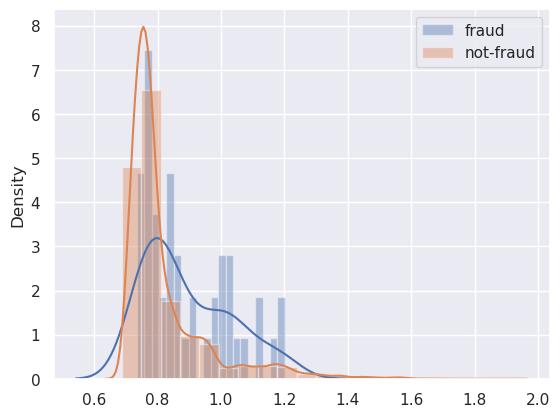

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sns.distplot(positives_scores, label='fraud', bins=20)
sns.distplot(negatives_scores, label='not-fraud', bins=20)
plt.legend()

## Generating Trafic and realtime prediction

In [20]:
import warnings
warnings.filterwarnings('ignore')

import logging

logging.basicConfig()
logging.getLogger('botocore.credentials').setLevel(logging.WARNING)

In [21]:
force_traffic_generation = False

We initiate the generation of endpoint traffic for model evaluation. If the SageMaker mode is set to *"NotebookInstance"* or if explicitly forced by `force_traffic_generation`, it launches a separate thread to execute the generate_traffic function, passing a copy of the test data `(X_test)` as an argument.

In [24]:
import numpy as np
from threading import Thread
from package.generate_endpoint_traffic import generate_traffic

if config.SAGEMAKER_MODE == "NotebookInstance" or force_traffic_generation:
    thread = Thread(target = generate_traffic, args=[np.copy(X_test)])
    thread.start()

In [25]:
from IPython.display import Markdown as md

# We Print variable values
print(f"SAGEMAKER_MODE: {config.SAGEMAKER_MODE}")
print(f"force_traffic_generation: {force_traffic_generation}")
print(f"AWS_REGION: {config.AWS_REGION}")
print(f"SOLUTION_PREFIX: {config.SOLUTION_PREFIX}")

md(f"[Link to Lambda Monitoring](https://{config.AWS_REGION}.console.aws.amazon.com/lambda/home?region={config.AWS_REGION}#/functions/{config.SOLUTION_PREFIX}-event-processor?tab=monitoring)")
    

SAGEMAKER_MODE: NotebookInstance
force_traffic_generation: False
AWS_REGION: eu-west-3
SOLUTION_PREFIX: sagemaker-soln-fdml-


[Link to Lambda Monitoring](https://eu-west-3.console.aws.amazon.com/lambda/home?region=eu-west-3#/functions/sagemaker-soln-fdml--event-processor?tab=monitoring)

 here we configure a Real-Time Predictor `(rcf_real_time_predictor)` for the deployed Random Cut Forest (RCF) model using SageMaker. We set the endpoint name, serializer, deserializer (set to None for custom processing), and content type for making predictions

In [26]:
from sagemaker.predictor import RealTimePredictor

rcf_real_time_predictor = RealTimePredictor(endpoint_name="{}-rcff".format(config.SOLUTION_PREFIX),
                          serializer=CSVSerializer(),
                          deserializer=None,
                          content_type='text/csv')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Then we configure our real-time predictor excaly how we did for the previous predictor 

In [27]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        result = current_predictor.predict(array)
        predicted_values = [item['score'] for item in result['scores']]
        predictions.extend(predicted_values)

    return predictions

rcf_real_time_predictor.content_type = 'text/csv'
rcf_real_time_predictor.serializer = CSVSerializer()
rcf_real_time_predictor.accept = 'application/json'
rcf_real_time_predictor.deserializer = JSONDeserializer()

### Clustering Anomaly Scores Using K-Means

To obtain a clear representation of the two distributions after assigning a score to each transaction, we opted to utilize K-means clustering for visual separation.

In [28]:
# We Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# We Obtain anomaly scores using the Real-Time Predictor for the Random Cut Forest (RCF) model
scores = np.array(predict(rcf_real_time_predictor, X_test)).reshape(-1, 1)

# We Specify the number of clusters for K-Means
num_clusters = 2

# We Apply K-Means clustering to the anomaly scores
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scores)

# We Assign cluster labels
labels = kmeans.labels_

# We Separate anomaly scores into clusters
cluster1 = scores[labels == 0]
cluster2 = scores[labels == 1]

Then we plot the distributions of the two clusters based on the clustering results 

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.distplot(cluster1.flatten(), color='blue', label='Cluster 1')
sns.distplot(cluster2.flatten(), color='orange', label='Cluster 2')

plt.title('Density Plot of Scores in Both Clusters')
plt.xlabel('Scores')
plt.ylabel('Density')
plt.legend()

plt.show()

and finally we delete the models and endpoints associated with the Batch Transform and Real-Time Predictions Random Cut Forest (RCF) models and we clean our environements for future uses.

In [ ]:
rcf_predictor.delete_model()
rcf_predictor.delete_endpoint()
rcf_real_time_predictor.delete_model()
rcf_real_time_predictor.delete_endpoint()
sm_client = boto3.client('sagemaker', region_name=config.AWS_REGION)
waiter = sm_client.get_waiter('endpoint_deleted')
waiter.wait(EndpointName="{}-rcff".format(config.SOLUTION_PREFIX))

## **Conclusion**

In this project, we have successfully demonstrated the deployment and evaluation of a Random Cut Forest (RCF) model for credit card fraud detection using Amazon SageMaker. The key phases included setting up the environment, training and deploying the model, processing and engineering features, and finally, evaluating the model's performance through clustering and traffic generation.

The significance of this project is evident in its direct applicability to real-world scenarios where credit card fraud presents a considerable threat. By harnessing machine learning models like RCF, Zen Netwrok can bolster their fraud and anomally detection capabilities, thereby fortifying financial transactions and shielding customers from unauthorized activities.

This project furnishes a scalable framework adaptable to larger datasets (similar to what we actually have for Zen Netwrok), empowering the company to implement robust fraud detection systems.